# Train model

### Imports

In [43]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import joblib

import shap
import lime
from lime import lime_tabular

### Load the dataset

In [44]:
df = pd.read_pickle('../artifacts/trainset.pkl')

In [45]:
df.head()

,main_diagnosis,type_of_care_discharge_needed,care_level,heart_rate_at_admission,temperature_at_admission,gender,care_duration_in_days_until_search_started,co_morbidities,mobility,discharge_time_days,systolic_pressure,diastolic_pressure,heart_rate_binned,systolic_pressure_binned,num_comorbidities,heart_rate_systolic_interaction,care_level_mobility_interaction,care_duration_log
0,Heart failure (ICD-10: I50),home care,3,82,36.5,female,0,Chronic Kidney Disease,walk with help,12,120,80,normal,normal,1,9840,0,0.0
1,Acute appendicitis (ICD-10: K35),no needed,3,63,36.9,diverse,0,Chronic Pain,walk with help,0,120,80,normal,normal,1,7560,0,0.0
2,Asthma (ICD-10: J45),no needed,4,86,37.6,female,0,Obesity,walk with help,0,130,85,normal,elevated,1,11180,0,0.0
3,Lower back pain (ICD-10: M54),no needed,4,77,37.4,female,0,Obesity,wheelchair,0,140,90,normal,elevated,1,10780,0,0.0
4,Heart failure (ICD-10: I50),short term stationary care,unknown,80,36.3,male,0,None,walk with help,11,120,80,normal,normal,1,9600,0,0.0


### Check column types

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   main_diagnosis                              1000 non-null   category
 1   type_of_care_discharge_needed               1000 non-null   category
 2   care_level                                  1000 non-null   category
 3   heart_rate_at_admission                     1000 non-null   int64   
 4   temperature_at_admission                    1000 non-null   float64 
 5   gender                                      1000 non-null   category
 6   care_duration_in_days_until_search_started  1000 non-null   int64   
 7   co_morbidities                              1000 non-null   category
 8   mobility                                    1000 non-null   category
 9   discharge_time_days                         1000 non-null   int64   
 10  s

### Preparing for Model Training

In [47]:
X = df.drop(columns=['discharge_time_days'])
y = df['discharge_time_days']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
X_train.columns

Index(['heart_rate_at_admission', 'temperature_at_admission',
       'care_duration_in_days_until_search_started', 'systolic_pressure',
       'diastolic_pressure', 'num_comorbidities',
       'heart_rate_systolic_interaction', 'care_duration_log',
       'main_diagnosis_Asthma (ICD-10: J45)',
       'main_diagnosis_Chronic kidney disease (ICD-10: N18)',
       'main_diagnosis_Chronic obstructive pulmonary disease (ICD-10: J44)',
       'main_diagnosis_Diabetes mellitus type 1 (ICD-10: E10)',
       'main_diagnosis_Diabetes mellitus type 2 (ICD-10: E11)',
       'main_diagnosis_Heart failure (ICD-10: I50)',
       'main_diagnosis_Hypertension (ICD-10: I10)',
       'main_diagnosis_Lower back pain (ICD-10: M54)',
       'type_of_care_discharge_needed_mobile care',
       'type_of_care_discharge_needed_no needed',
       'type_of_care_discharge_needed_short term stationary care',
       'type_of_care_discharge_needed_stationary care', 'care_level_1',
       'care_level_2', 'care_level_3'

In [49]:
X_train.head()

,heart_rate_at_admission,temperature_at_admission,care_duration_in_days_until_search_started,systolic_pressure,diastolic_pressure,num_comorbidities,heart_rate_systolic_interaction,care_duration_log,main_diagnosis_Asthma (ICD-10: J45),main_diagnosis_Chronic kidney disease (ICD-10: N18),...,heart_rate_binned_high,systolic_pressure_binned_elevated,systolic_pressure_binned_high,care_level_mobility_interaction_0,care_level_mobility_interaction_1,care_level_mobility_interaction_2,care_level_mobility_interaction_3,care_level_mobility_interaction_4,care_level_mobility_interaction_5,care_level_mobility_interaction_unknown
29,98,36.4,0,130,85,2,12740,0.0,False,False,...,False,True,False,False,False,False,False,False,False,False
535,81,37.6,0,130,85,1,10530,0.0,False,False,...,False,True,False,False,False,False,False,False,False,False
695,98,36.1,0,150,95,2,14700,0.0,True,False,...,False,False,True,False,False,False,False,False,False,False
557,70,36.5,0,120,80,2,8400,0.0,False,False,...,False,False,False,False,True,False,False,False,False,False
836,78,37.6,0,150,95,2,11700,0.0,False,True,...,False,False,True,False,False,False,False,False,False,False


### Create Model configs for training

In [50]:
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

### Hyperparameters

In [51]:
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 1.5, 2]  # L2 regularization
}


### GridSearchCV to find the best hyperparameters

In [52]:
grid_search = GridSearchCV(estimator=xgboost_model, 
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error', 
                           cv=5, 
                           verbose=1, 
                           n_jobs=-1)

### Training

In [53]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6], 'n_estimators': [100, 200],
                         'reg_alpha': [0, 0.1, 1], 'reg_lambda': [1, 1.5, 2]},
             scoring='neg_mean_absolute_error', verbose=1)

### Best parameters and best score

In [54]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MAE):", -grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 2}
Best Score (MAE): 1.1182827851445474


### Validation

In [55]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

predictions = np.maximum(predictions, 0)

# Round the predictions to get integer values
predictions = predictions.round().astype(int)

In [56]:
predictions[:70]

array([ 0,  9,  0,  5,  6,  5,  5,  6,  5,  0,  6,  0,  0,  6,  6,  9,  9,
        0,  8,  0,  0,  5,  7,  0,  5,  6,  0, 12,  6,  6,  0,  0,  0,  8,
        8,  0,  0,  0,  7,  0, 15,  0,  6,  0,  5,  0,  7,  7, 12,  0,  0,
        6,  6,  0,  0,  6,  6,  6,  6,  7,  5, 15,  0,  0,  0,  6,  0,  0,
        7,  0])

# Model evaluation

#### Errors

In [57]:
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 1.075
Root Mean Squared Error: 1.7219175357722565


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


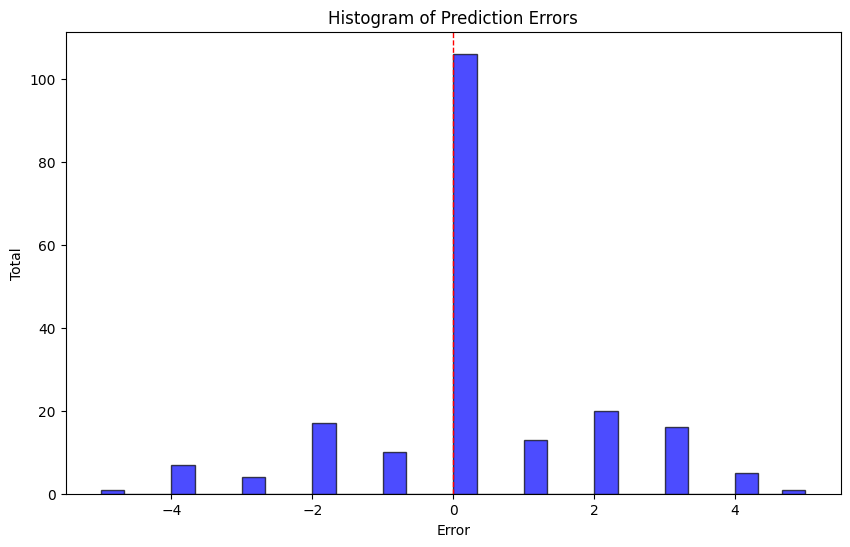

In [58]:
error = predictions - y_test
plt.figure(figsize=(10, 6))
plt.hist(error, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Total')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.show()

### Feature importances

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


importances = best_model.feature_importances_

features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df)

                                              Feature  Importance
17            type_of_care_discharge_needed_no needed    0.280718
13         main_diagnosis_Heart failure (ICD-10: I50)    0.137291
10  main_diagnosis_Chronic obstructive pulmonary d...    0.099385
9   main_diagnosis_Chronic kidney disease (ICD-10:...    0.084681
11  main_diagnosis_Diabetes mellitus type 1 (ICD-1...    0.083064
8                 main_diagnosis_Asthma (ICD-10: J45)    0.066411
12  main_diagnosis_Diabetes mellitus type 2 (ICD-1...    0.051808
14          main_diagnosis_Hypertension (ICD-10: I10)    0.045851
15       main_diagnosis_Lower back pain (ICD-10: M54)    0.040123
18  type_of_care_discharge_needed_short term stati...    0.007893
36                         mobility_walk without help    0.005271
30                       co_morbidities_Heart Disease    0.004674
6                     heart_rate_systolic_interaction    0.004669
40                  systolic_pressure_binned_elevated    0.004589
42        

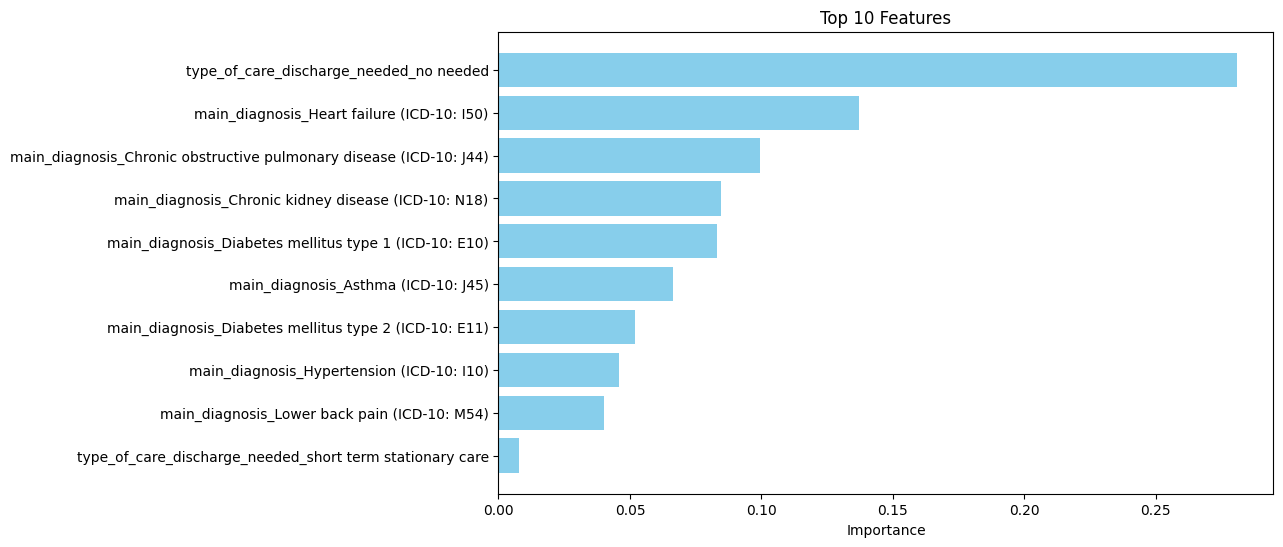

In [60]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Features')
plt.gca().invert_yaxis()
plt.show()

# Explainability

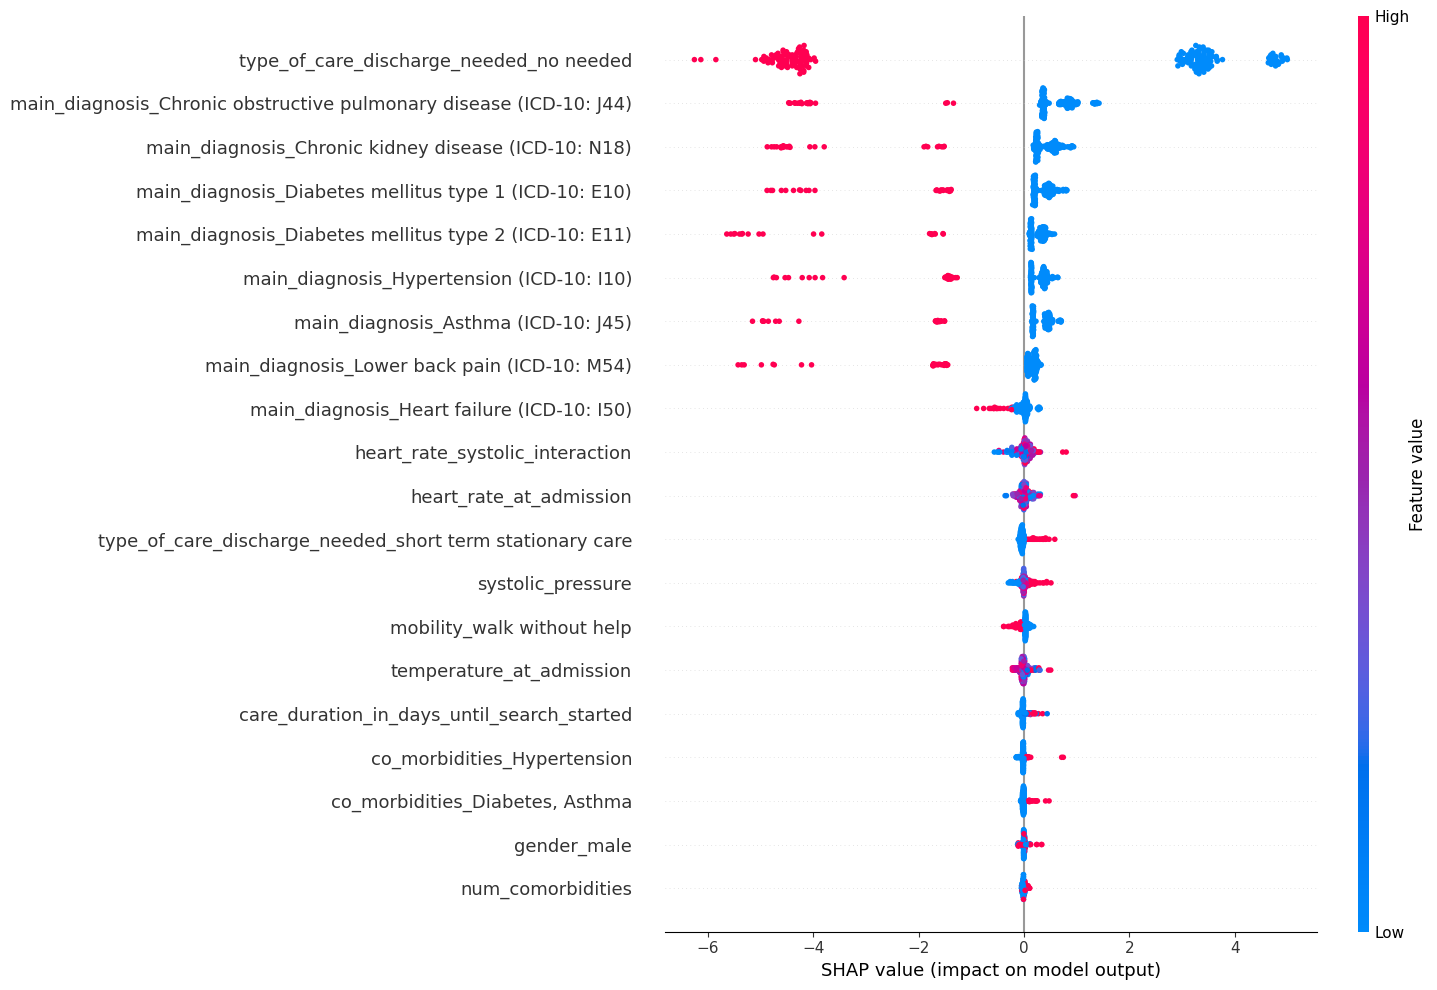

In [61]:
explainer = shap.TreeExplainer(best_model)
shap_values_test = explainer.shap_values(X_test)
plt.figure(figsize=(120, 8))
shap.summary_plot(shap_values_test, X_test, plot_size=(15,10))

### Local Interpretable Model-agnostic Explanations

In [62]:
explainer = lime_tabular.LimeTabularExplainer(X.values, feature_names=X_test.columns, class_names=['discharge_time_days'], mode='regression')

i = 0  # Index of the instance
exp = explainer.explain_instance(X_test.values[i], best_model.predict)

exp.show_in_notebook(show_table=True)

### Export model to pkl

In [20]:
joblib.dump(best_model, '../artifacts/model.joblib')

['model.joblib']